<a href="https://colab.research.google.com/github/infiniteDipia/CNN/blob/main/GoogLnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 163s 413ms/step - accuracy: 0.5197 - loss: 0.6924 - val_accuracy: 0.5813 - val_loss: 0.6815
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 127s 255ms/step - accuracy: 0.5994 - loss: 0.6660 - val_accuracy: 0.6824 - val_loss: 0.5973
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 102s 323ms/step - accuracy: 0.6935 - loss: 0.5859 - val_accuracy: 0.7404 - val_loss: 0.5285
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 142s 322ms/step - accuracy: 0.7481 - loss: 0.5179 - val_accuracy: 0.7935 - val_loss: 0.4581
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 96s 323ms/step - accuracy: 0.7936 - loss: 0.4472 - val_accuracy: 0.8296 - val_loss: 0.4054
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 122s 255ms/step - accuracy: 0.8393 - loss: 0.3712 - val_accuracy: 0.8491 - val_loss: 0.3565
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 102s 324ms/step - accuracy: 0.8638 - loss: 0.3184 - val_accuracy: 0.8762 - val_loss: 0.2891
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 141s 322ms/step - accuracy: 0.8908 - 

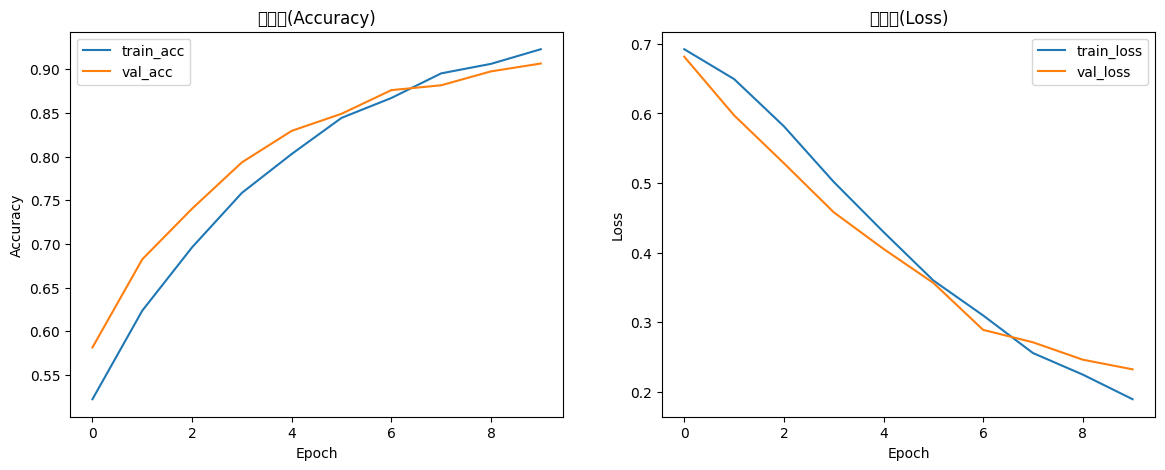

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, concatenate, Dropout, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# 하이퍼파라미터
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.0002

# 1. 데이터셋 로드 및 전처리
def preprocess(data):
    x = tf.image.resize(data['image'], IMG_SIZE)
    x = tf.cast(x, tf.float32) / 255.
    y = data['label']
    y = tf.one_hot(y, 2)
    return x, y

ds, info = tfds.load('cats_vs_dogs', split='train', with_info=True, as_supervised=False)
n_total = info.splits['train'].num_examples
n_train = int(n_total * 0.8)
ds = ds.shuffle(1024, reshuffle_each_iteration=False)
train_ds = ds.take(n_train).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds.skip(n_train).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 2. 인셉션(GoogLeNet) 모듈
def inception_module(x, f):
    path1 = Conv2D(f[0], (1,1), padding='same', activation='relu')(x)
    path2 = Conv2D(f[1], (1,1), padding='same', activation='relu')(x)
    path2 = Conv2D(f[2], (3,3), padding='same', activation='relu')(path2)
    path3 = Conv2D(f[3], (1,1), padding='same', activation='relu')(x)
    path3 = Conv2D(f[4], (5,5), padding='same', activation='relu')(path3)
    path4 = MaxPool2D((3,3), strides=(1,1), padding='same')(x)
    path4 = Conv2D(f[5], (1,1), padding='same', activation='relu')(path4)
    return concatenate([path1, path2, path3, path4], axis=-1)

# 3. GoogLeNet 구성
def build_googlenet(input_shape=(150,150,3), num_classes=2):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(inputs)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_module(x, [64,96,128,16,32,32])
    x = inception_module(x, [128,128,192,32,96,64])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_module(x, [192,96,208,16,48,64])
    x = inception_module(x, [160,112,224,24,64,64])
    x = inception_module(x, [128,128,256,24,64,64])
    x = inception_module(x, [112,144,288,32,64,64])
    x = inception_module(x, [256,160,320,32,128,128])
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = inception_module(x, [256,160,320,32,128,128])
    x = inception_module(x, [384,192,384,48,128,128])

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# 4. 모델 생성 및 학습
model = build_googlenet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=2)
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

# 5. 훈련 정확도 & 손실률 그래프
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('정확도(Accuracy)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('손실률(Loss)')
plt.legend()

plt.show()
